[Reference](https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/densenet-cifar10-2.4.1.py)

In [1]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam,RMSprop
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

In [2]:
batch_size = 128
num_classes = 10
epochs = 10
l = 12
num_filter = 36#adding extra filters to get more trainable params
compression = 0.5
dropout_rate = 0.2

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [4]:
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same',kernel_initializer='he_normal')(relu)
        #if dropout_rate>0:
        #    Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [5]:
## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same',kernel_initializer='he_normal')(relu)
    #if dropout_rate>0:
     #    Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

In [6]:
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    #flat = layers.Flatten()(AvgPooling)
    #output = layers.Dense(num_classes, activation='softmax')(flat)
    output=layers.Conv2D(10,kernel_size= (2,2) ,strides=(1,1),padding='valid',kernel_initializer='he_normal',
    data_format='channels_last',activation='softmax')(AvgPooling)
    output=layers.Flatten()(output)
    return output

In [7]:
num_filter = 36
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [8]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 36)   972         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 36)   144         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 36)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### Epoch 0-40

In [9]:
datagen = ImageDataGenerator(rotation_range = 15, horizontal_flip = True, width_shift_range = 0.15, height_shift_range = 0.15, zoom_range = 0.2, shear_range = 15)
datagen.fit(x_train)

In [12]:
check = ModelCheckpoint("mod/best.hdf5", monitor = 'val_accuracy')


In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(1e-2),
              metrics=['accuracy'])

In [13]:
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size), steps_per_epoch = x_train.shape[0]//batch_size, epochs = 40, validation_data =(x_test, y_test), callbacks = [check])
model.save('mod/40epochs.hdf5')

Epoch 1/40
390/390 [==============================] - 331s 849ms/step - loss: 2.1513 - accuracy: 0.2508 - val_loss: 1.7459 - val_accuracy: 0.3581
Epoch 2/40
390/390 [==============================] - 338s 866ms/step - loss: 1.5566 - accuracy: 0.4311 - val_loss: 1.6241 - val_accuracy: 0.4420
Epoch 3/40
390/390 [==============================] - 355s 911ms/step - loss: 1.2840 - accuracy: 0.5329 - val_loss: 1.5301 - val_accuracy: 0.4974
Epoch 4/40
390/390 [==============================] - 345s 884ms/step - loss: 1.1037 - accuracy: 0.6025 - val_loss: 1.3198 - val_accuracy: 0.5761
Epoch 5/40
390/390 [==============================] - 339s 870ms/step - loss: 0.9863 - accuracy: 0.6466 - val_loss: 1.1603 - val_accuracy: 0.5990
Epoch 6/40
390/390 [==============================] - 347s 890ms/step - loss: 0.8966 - accuracy: 0.6799 - val_loss: 1.1410 - val_accuracy: 0.6544
Epoch 7/40
390/390 [==============================] - 338s 867ms/step - loss: 0.8307 - accuracy: 0.7073 - val_loss: 1.2358 -

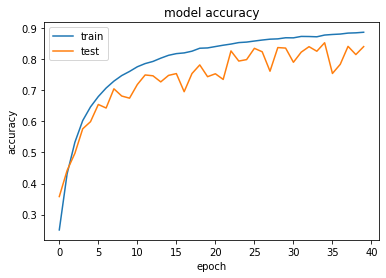

In [14]:
 plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

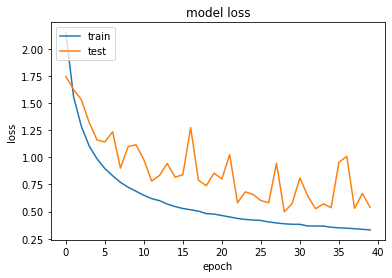

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Epoch 40-80

In [4]:
model = load_model('mod/best.hdf5')

In [5]:
datagen = ImageDataGenerator(rotation_range = 15, horizontal_flip = True, width_shift_range = 0.15, height_shift_range = 0.15, zoom_range = 0.2, shear_range = 15)
datagen.fit(x_train)
check = ModelCheckpoint("mod/best.hdf5", monitor = 'val_accuracy')

#lr_sche = LearningRateScheduler(lr_schedule)

lr_plt = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=7,
                               min_lr=0.5e-6,verbose=1)


In [6]:
tf.keras.backend.set_value(model.optimizer.lr, .005)                       
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size), steps_per_epoch = x_train.shape[0]//batch_size, epochs = 40, validation_data =(x_test, y_test), callbacks = [check,lr_plt])
model.save('mod/epoch80.hdf5')

Epoch 1/40
390/390 [==============================] - 300s 769ms/step - loss: 0.2747 - accuracy: 0.9060 - val_loss: 0.4142 - val_accuracy: 0.8813
Epoch 2/40
390/390 [==============================] - 296s 760ms/step - loss: 0.2625 - accuracy: 0.9090 - val_loss: 0.3748 - val_accuracy: 0.8901
Epoch 3/40
390/390 [==============================] - 316s 810ms/step - loss: 0.2561 - accuracy: 0.9119 - val_loss: 0.3752 - val_accuracy: 0.8874
Epoch 4/40
390/390 [==============================] - 304s 780ms/step - loss: 0.2523 - accuracy: 0.9138 - val_loss: 0.3974 - val_accuracy: 0.8852
Epoch 5/40
390/390 [==============================] - 309s 792ms/step - loss: 0.2491 - accuracy: 0.9143 - val_loss: 0.3886 - val_accuracy: 0.8911
Epoch 6/40
390/390 [==============================] - 308s 790ms/step - loss: 0.2470 - accuracy: 0.9148 - val_loss: 0.3946 - val_accuracy: 0.8899
Epoch 7/40
390/390 [==============================] - 310s 795ms/step - loss: 0.2437 - accuracy: 0.9159 - val_loss: 0.3948 -

In [4]:
model = load_model('mod/best.hdf5')

In [5]:
r=model.evaluate(x_test,y_test,verbose=0)

In [6]:
print("cross entopy on test data=",r[0])
print("accuracy on test data=",r[1])

cross entopy on test data= 0.3108436535924673
accuracy on test data= 0.9128


### Summary:


1. got 91% test accuracy within 80 epochs
2. added he initializer in conv2d layers for dense and transition blocks
3. increase number of filters to get more trainable params
4. removed droputs in dense and transition blocks since data augmentation is done (got this idea from reference link)